### Q Learning

Q learning is a reinforcement (machine) learning algorithm. It develops a policy to maximize expected rewards based on collected experiences.

#### States, actions and rewards

The agent's task when presented with a given state $S$ is to select an action $A$ resulting in a new state $S_{+1}$. Some of the states might offer the agent feedback in the form of a positive or negative reward. The rewards are evaluated to create the policy.

#### Markov learning process

A Markov chain is a sequence of events, where the probability of the next event depends only on the current state. For the Q Learner the assumption that the environment is a Markov process simplifies the decision finding. The Q Table only needs to assign expected reward values to each action considering only the agent's current state.

#### Q Table

The Q Table is a matrix $Q_{({actions} \times {states})}$. For a given state $S$ the expected value of each action can be immediately accessed from the Table and the action with the highest value can be chosen.

### Q Table update rule

During training after each action the agent updates the Q table. 

If from the state $S$ the action $A$ was taken resulting in a new state $S_{+1}$ and the reward $R$ update as follows:

$Q_{update}(S, A) = (1 - \alpha) \cdot Q_{current}(S, A) + \alpha \cdot (R + \gamma \cdot max(Q(S_{+1}, A_{i})))$

with $\alpha \in [0:1]$ the learning rate and $\gamma \in [0:1]$ the discount factor for expected future rewards. $max(Q(S_{+1}, A_{i}))$ is the maximum reward (as recorded in the current Q-Table) for all possible actions $A_{i}$ in the next state $S_{+1}$. It is used as an estimation for the expected future rewards.

### Imports and Helper functions

#### Imports

In [1]:
import os
from pathlib import Path

BASE_DIR = Path(__name__).parent.absolute()
os.chdir(BASE_DIR)

from maze_agent_access import MazeAgentAccess as Maa
from q_learner import QLearner

from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### def flatten(x, y, dim_x):

In [2]:
def flatten(x, y, dim_x):
    """ flattens 2 dimensional coordinates into a flat index (state ID)"""
    return x + y * dim_x

#### def visualize_qtable(dim_x, dim_y, qtable):

In [3]:
def visualize_qtable(dim_x, dim_y, qtable):
    """ reformats the q-table to get a map like representation. 
        this is specific to this demo, since the mapping of states and actions
        depends on the setting. 
    """
    # actions order: left, right, up, down
    value_map = [[0.0 for _ in range(dim_x)] for _ in range(dim_y)]
    count_map = [[0 for _ in range(dim_x)] for _ in range(dim_y)]

    for i in range(dim_x):
        for j in range(dim_y):

            if(i-1) >= 0:
                value_map[j][i-1] += qtable[flatten(i, j, dim_x)][0]
                count_map[j][i-1] += 1
            if(i+1) < dim_x:
                value_map[j][i+1] += qtable[flatten(i, j, dim_x)][1]
                count_map[j][i+1] += 1
            if(j-1) >= 0:
                value_map[j-1][i] += qtable[flatten(i, j, dim_x)][2]
                count_map[j-1][i] += 1
            if(j+1) < dim_y:
                value_map[j+1][i] += qtable[flatten(i, j, dim_x)][3]
                count_map[j+1][i] += 1 

    for i in range(dim_y):
        for j in range(dim_x):
            value_map[i][j] = value_map[i][j] / count_map[i][j]

    matrix = np.array(value_map)
    cmap = plt.get_cmap("RdYlGn")
    plt.imshow(matrix, cmap=cmap, interpolation="nearest", aspect="auto")
    plt.colorbar()
    plt.title("Rewards map")
    plt.show()

    return value_map

#### def run_episodes(num_episodes, max_steps, reward_values, qagent, ql):

In [4]:
def run_episodes(num_episodes, max_steps, reward_values, qagent, ql):
    for _ in range(num_episodes):
        qagent.reset_to_start()
        next_episode = False
        for _ in range(max_steps):
            reward = reward_values["REWARD_STEP"]
            state = flatten(qagent.pos_x, qagent.pos_y, qagent.maze.dim_x)
            action = ql.epsilon_greedy_action(state)
            action_function = qagent.action_space[action]
            state_change = action_function()

            if not state_change:
                reward = reward_values["REWARD_WALL"]
            if qagent.is_at_goal:
                reward = reward_values["REWARD_GOAL"]
                next_episode = True
            if qagent.is_in_hole:
                reward = reward_values["REWARD_HOLE"]
                next_episode = True

            new_state = flatten(qagent.pos_x, qagent.pos_y, qagent.maze.dim_x)
            ql.update_q(
                s=state,
                a=action,
                s_next=new_state,
                reward=reward
            )

            if next_episode:
                break

## Frozen Lake

A pathfinding setting in a grid based environment. The agent has to learn how to navigate the maze to the exit. The maze has two kinds of obstacles: walls just block the movement into a grid cell, while holes in the ice reset the agent back to the start ("ending the episode")

In the example below walls are solid, traversable grids are the crossed lines and holes are black. The agent starts at @ (0, 0) and the goal grid G is (4, 4)

In [5]:
example = Maa(name="Frozen Lake Example", maze_foldername="FrozenLake_5x5")
print(example.get_maze_view_buffer())

Frozen Lake Example @ FrozenLake_5x5
█████████████████████ Y
███ @ ─┼──┼──┼──┼─███ 0
███─┼─   ─┼─   ─┼─███ 1
███─┼──┼──┼──┼──┼─███ 2
███─┼─   ███─┼──┼─███ 3
███─┼──┼─███─┼─ G ███ 4
█████████████████████ ↓
 X  0  1  2  3  4  → 


### State and Action spaces
* States are the grid cells. We use a flat numbering S = x + y * width.
* Actions are the possible moves A = {left, right, up, down}

The agent has no access to the overview map or the grid representation and must learn and make decisions based solely on experienced outcomes of attempted actions out of a given state.

## The Learning process

In [6]:
qagent = Maa(name="Quinn", maze_foldername="FrozenLake_12x10")
print(qagent.get_maze_view_buffer())

Quinn @ FrozenLake_12x10
██████████████████████████████████████████ Y
███─┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼─███ 0
███─┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼──┼─███ 1
███─┼──┼──┼─███─┼─█████████─┼──┼──┼──┼─███ 2
███ @ ─┼─██████─┼──┼──┼──┼──┼──┼──┼──┼─███ 3
███─┼──┼─██████─┼──┼─         ─┼──┼──┼─███ 4
███─┼──┼─██████─┼──┼──┼──┼──┼──┼──┼──┼─███ 5
███─┼──┼──┼─███─┼─██████─┼──┼──┼─███─┼─███ 6
███─┼──┼──┼──┼──┼─███─┼──┼──┼──┼─███ G ███ 7
███─┼─   ─┼──┼──┼─███─┼──┼──┼──┼─███─┼─███ 8
███─┼─   ─┼──┼──┼─███─┼──┼──┼──┼──┼──┼─███ 9
██████████████████████████████████████████ ↓
 X  0  1  2  3  4  5  6  7  8  9 10 11  → 


#### Rewards

In [7]:
REWARD_POLICY = {
    "REWARD_HOLE": -1.0,
    "REWARD_WALL": -0.75,
    "REWARD_GOAL": 2.0,
    "REWARD_STEP": -0.1
}

# learning passes
EPISODES = 1000
MAX_STEPS_FACTOR = 10

#### Meta parameters
* alpha: The learning rate. 1: only beleive the new information, 0: keep old information
* gamma: Temporal discount for the vlaue of (expected) future rewards. 0: disregard future rewards
* epsilon: Exploration rate for the explore-vs-exploit policy. The chance to randomply explore.

In [8]:
ALPHA = 0.5  
GAMMA = 0.5 
EPSILON = 0.5 

#### Q-Learner setup

In [9]:
dim_x = qagent.maze.dim_x
dim_y = qagent.maze.dim_y 
states = dim_x * dim_y
max_steps = states * MAX_STEPS_FACTOR
actions = qagent.action_space

ql = QLearner(
    filename="not set",
    states=states,
    actions=len(actions),
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON
)

#### Run learning episodes

In [10]:
run_episodes(
    num_episodes=EPISODES,
    max_steps=max_steps,
    reward_values=REWARD_POLICY,
    qagent=qagent,
    ql=ql
)

## Results
#### Raw Q-Table

In [11]:
q_matrix = pd.DataFrame(ql.qtable)
q_matrix

,0,1,2,3
0,-0.849719,-0.199983,-0.849989,-0.199983
1,-0.199992,-0.199966,-0.849983,-0.199966
2,-0.199983,-0.199933,-0.849966,-0.199933
3,-0.199966,-0.199866,-0.849933,-0.199866
4,-0.199933,-0.199731,-0.849866,-0.199731
...,...,...,...,...
115,-0.175513,-0.168604,-0.165447,-0.736719
116,-0.174584,-0.134424,-0.172383,-0.749414
117,-0.154882,-0.004492,-0.128418,-0.375000
118,-0.111768,0.283594,-0.680957,-0.659277


#### Use the learned policy to navigate the maze

In [12]:
qagent.maze.start=(0,0)

qagent.reset_to_start()
ql.epsilon = 0
qagent.draw_trace = True

while not qagent.is_at_goal:
    state = flatten(qagent.pos_x, qagent.pos_y, dim_x)
    action_fn = actions[ql.epsilon_greedy_action(state)]
    action_fn()
    if qagent.is_in_hole:
        qagent.reset_to_start()

print(qagent.get_maze_view_buffer())

Quinn @ FrozenLake_12x10
██████████████████████████████████████████ Y
███ @  @  @ ─┼──┼──┼─ @  @  @  @ ─┼──┼─███ 0
███─┼─ @  @  @  @  @  @  @  @  @  @  @ ███ 1
███─┼──┼──┼─███─┼─█████████─┼─ @  @  @ ███ 2
███─┼──┼─██████─┼──┼──┼──┼──┼──┼──┼─ @ ███ 3
███─┼──┼─██████─┼──┼─         ─┼─ @  @ ███ 4
███─┼──┼─██████─┼──┼──┼──┼──┼──┼─ @  @ ███ 5
███─┼──┼──┼─███─┼─██████─┼──┼──┼─███ @ ███ 6
███─┼──┼──┼──┼──┼─███─┼──┼──┼──┼─███ @ ███ 7
███─┼─   ─┼──┼──┼─███─┼──┼──┼──┼─███─┼─███ 8
███─┼─   ─┼──┼──┼─███─┼──┼──┼──┼──┼──┼─███ 9
██████████████████████████████████████████ ↓
 X  0  1  2  3  4  5  6  7  8  9 10 11  → 


#### Q-Weights visualized

The chart shows the average reward the agent is expecting to receive by entering a given grid cell. The holes are clearly identified with the deep red and the walls in orange. A gradient of increasing rewards is seen around the goal grid.

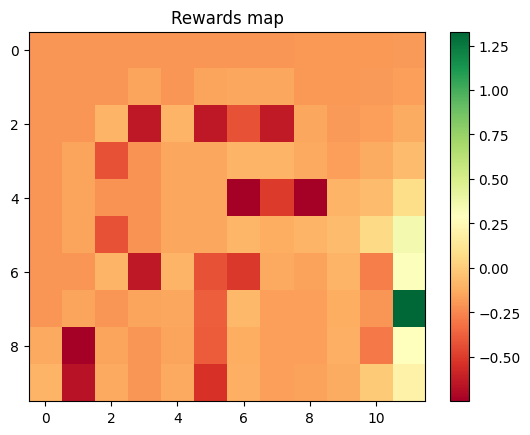

In [13]:
_ = visualize_qtable(dim_x, dim_y, ql.qtable)

#### A different maze

In [14]:
qagent = Maa(name="Quinn", maze_foldername="FrozenLake_5x5")
print(qagent.get_maze_view_buffer())

Quinn @ FrozenLake_5x5
█████████████████████ Y
███ @ ─┼──┼──┼──┼─███ 0
███─┼─   ─┼─   ─┼─███ 1
███─┼──┼──┼──┼──┼─███ 2
███─┼─   ███─┼──┼─███ 3
███─┼──┼─███─┼─ G ███ 4
█████████████████████ ↓
 X  0  1  2  3  4  → 


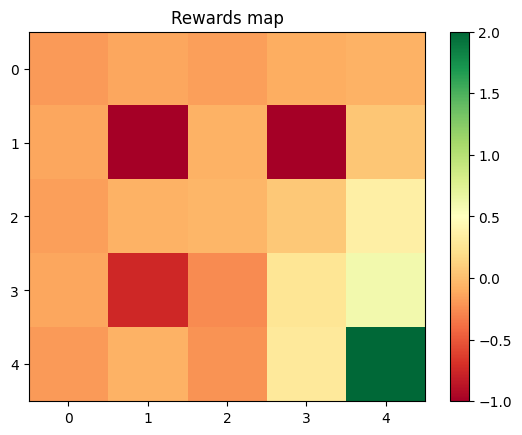

In [15]:
dim_x = qagent.maze.dim_x
dim_y = qagent.maze.dim_y 
states = dim_x * dim_y
max_steps = states * MAX_STEPS_FACTOR
actions = qagent.action_space

ql = QLearner(
    filename="not set",
    states=states,
    actions=len(actions),
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON
)

run_episodes(
    num_episodes=EPISODES,
    max_steps=max_steps,
    reward_values=REWARD_POLICY,
    qagent=qagent,
    ql=ql
)

_ = visualize_qtable(dim_x, dim_y, ql.qtable)

#### Linear algebra / Matrix notation
Consider the input state to be a vector of features: 

$S = (S_{0}, S_{1}, S_{2} \cdots S_{i})$.

In the Frozen Lake example above, where each state is encoded to be unqiely identified as it's own feature, the vector would be 

$S = (0, 0 \cdots S_{k}=1 \cdots 0)$ 
showing $1$ for the grid position $k$ and $0$ otherwise. 

If we interpret the Q-Table as a matrix, we can consider a different notation for the policy selection process: 

The multiplication:

$\begin{pmatrix} Q_{S_{0} \rightarrow A_{0}} & Q_{S_{1} \rightarrow A_{0}} & \cdots & Q_{S_{i} \rightarrow A_{0}} \\ 
\vdots & \vdots & \ddots & \vdots \\ 
Q_{S_{0} \rightarrow A_{j}} & Q_{S_{1} \rightarrow A_{j}} & \cdots & Q_{S_{i} \rightarrow A_{j}} \end{pmatrix} \cdot 
\begin{pmatrix} S_{0} \\ S_{1} \\ \vdots \\ S_{i} \end{pmatrix} = 
\begin{pmatrix} A_{0} \\ \vdots \\ A_{j} \end{pmatrix}$

yields a vector $A$ containing the weights (the expected rewards according to the policy) for each action $A_{j}$ given the state $S$
